### ResNet34
- 층수가 매우 많은 신경망은 vanishing gradient 문제가 발생한다
- 따라서 이를 해결하기 위해서 ``residual block(잔차 블록)`` 이 나왔다.
    - 뒤쪽 층의 기울기를 앞쪽 층에 직접 전달하는 별도의 경로를 추가 (스킵 연결)
    - 병목 잔차 블록 (bottleneck residual block)
        - 차원 축소가 적용된 블록
            - 축소 지름길 경로 (reduce short cut)
              - 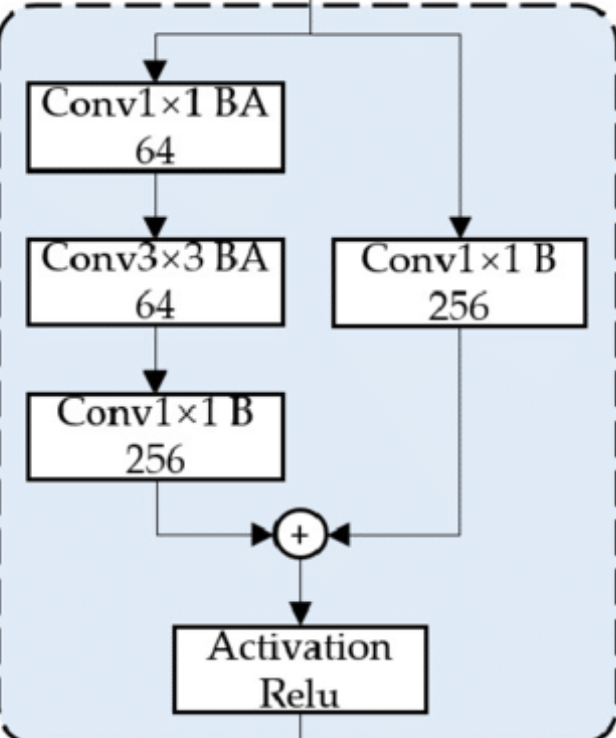
            - 일반 지름길 경로
              - 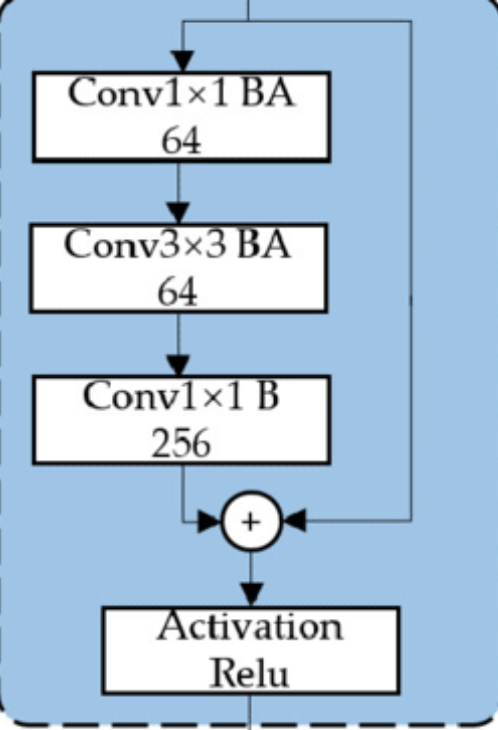

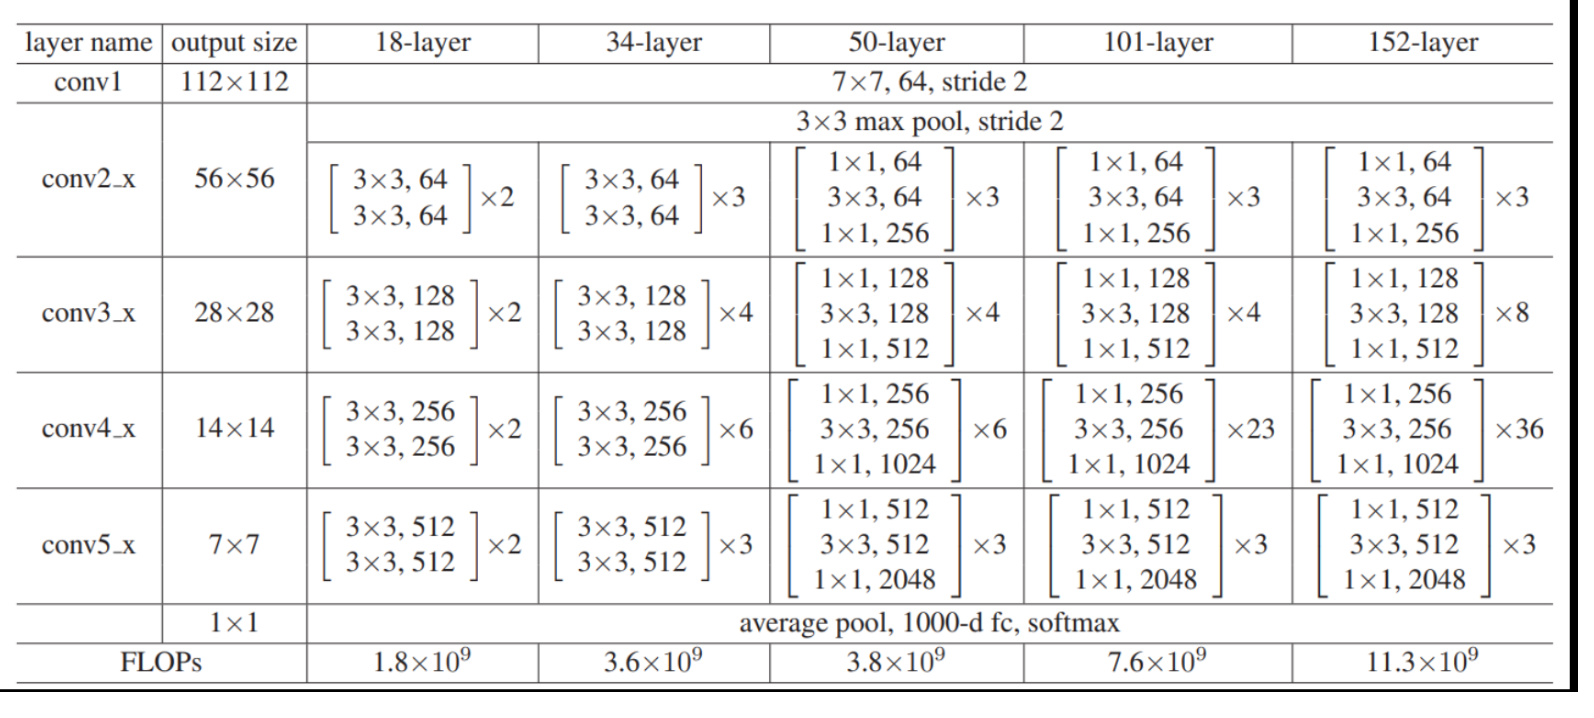

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from torchsummary import summary

In [10]:
class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, in_channels, out_channels, downsample = None, stride = 1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        identity = x # 지름길
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

In [33]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, downsample = None, stride = 1):
        super(Bottleneck,self).__init__()
        self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace = True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size =3 , padding=1, stride= stride)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.downsample = downsample
        self.stride = stride
    def forward(self,x):
        identity = x # 지름길
        
        _x = self.conv1(x) # 다른 변수로 선언해야한다. # identity가 안달라질수도 있어서
        _x = self.bn1(_x)
        _x = self.relu(_x)
        
        _x = self.conv2(_x)
        _x = self.bn2(_x)
        _x = self.relu(_x)
        _x = self.conv3(_x)
        _x = self.bn3(_x)

        if self.downsample is not None: 
            identity = self.downsample(identity)
            
        _x += identity
        return self.relu(_x)

In [34]:
class ResNet(nn.Module):
    def __init__(self,block = BasicBlock, layers = [2, 2, 2, 2], in_channels=3, num_classes=10):
        super(ResNet, self).__init__()

        self.inplanes = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, self.inplanes, kernel_size=7,stride=2, padding = 3), #패딩 값 어케 알아?
            nn.BatchNorm2d(self.inplanes),
            nn.ReLU(inplace=  True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding = 1) #패딩 값 어케 알아?
        )

        self.conv2_x = self.make_layer(block, layers[0], 64)
        self.conv3_x = self.make_layer(block, layers[1], 128, 2)
        self.conv4_x = self.make_layer(block, layers[2], 256, 2)
        self.conv5_x = self.make_layer(block, layers[3], 512, 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    
    def make_layer(self, block = BasicBlock, blocks = 2, in_channels = 3, stride = 1):
        downsample = None

        if (stride != 1 or self.inplanes != in_channels * block.expansion):
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, in_channels* block.expansion ,kernel_size=1,stride = stride),
                nn.BatchNorm2d(in_channels* block.expansion)
            )

        layers = []
        layers.append(block(self.inplanes, in_channels, downsample, stride))
        self.inplanes =  in_channels* block.expansion
        for _ in range(1,blocks):
            layers.append(
                block(self.inplanes, in_channels)
            )
        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x

In [35]:
model = ResNet(Bottleneck, [3, 4, 6, 3], 3, 10)
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,160
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,640
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,640
      BatchNorm2d-14          [-1, 256,